<a href="https://colab.research.google.com/github/harshalnishar/dcgan_cifar10/blob/master/gan_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements a deep convolutional generative adversarial network (DCGAN) to generate CIFAR-10 images from noise vector sampled from normal distribution.


In [ ]:
'''
Copyright 2020 [name of copyright owner]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''

In [ ]:
import numpy as np
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib
import pickle
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.contrib.training import HParams
from IPython.display import Image

hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    batch_size=32,  # training batch size
    dis_learning_rate=0.0001,
    gen_learning_rate=0.0004,
    n_epochs=50,  # number of epochs to train
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

Functions for Reading CIFAR-10 Dataset

In [ ]:
# Below code for reading CIFAR-10 dataset is taken from: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/cifar10.py
# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = hparams.n_classes

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path)

        print(" Done!")


def maybe_download_and_extract(url=data_url, download_dir=hparams.data_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(hparams.data_dir, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,encoding='bytes')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


def load_class_names():
    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls


def load_validation_data():

    images, cls = _load_data(filename="test_batch")

    images = images[5000:, :, :, :]
    cls = cls[5000:]

    return images, cls

def load_testing_data():


    images, cls = _load_data(filename="test_batch")

    images = images[:5000, :, :, :]
    cls = cls[:5000]

    return images, cls
  
maybe_download_and_extract()

# training data
x_train, y_train = load_training_data()
print("CIFAR-10 Training Dataset Size: ", x_train.shape)
print("CIFAR-10 Training Labels Size : ", y_train.shape)



Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_5
CIFAR-10 Training Dataset Size:  (50000, 32, 32, 3)
CIFAR-10 Training Labels Size :  (50000,)


Defining Some Helper Functions

In [ ]:
def conv_layer(input, filters, k_size = 3, strides = (1, 1), normalization = True, activation = tf.nn.leaky_relu, training = True, name = None):
  conv = tf.layers.conv2d(input, filters, k_size, strides, padding = 'same', name = name)
  if normalization:
    conv = tf.layers.batch_normalization(conv, training = training, trainable = False)
  if activation is not None:
    out = activation(conv)
  else:
    out = conv
  return out

def deconv_layer(input, filters, k_size = 3, strides = (2, 2), normalization = True, activation = tf.nn.relu, training = True, name = None):
  deconv = tf.layers.conv2d_transpose(input, filters, k_size, strides, padding = 'same', name = name)
  if normalization:
    deconv = tf.layers.batch_normalization(deconv, training = training)
  if activation is not None:
    out = activation(deconv)
  else:
    out = deconv
  return out

Defining Generator and Discriminator models

In [ ]:
tf.reset_default_graph()
def generator(latent_z, reuse = False):
  with tf.variable_scope('Generator', reuse = reuse) as scope:
    linear = tf.layers.dense(latent_z, 4 * 4 * 512, activation = tf.nn.relu, name = 'dense')
    linear_reshape = tf.reshape(linear, (-1, 4, 4, 512))
    conv_1 = deconv_layer(linear_reshape, filters = 128, k_size = 3, name = 'conv_1')
    conv_2 = deconv_layer(conv_1, filters = 64, k_size = 3, name = 'conv_2')
    conv_3 = deconv_layer(conv_2, filters = num_channels, k_size = 3, name = 'conv_3')
  return conv_3

def discriminator(image, reuse = False):
  with tf.variable_scope('Discriminator', reuse = reuse) as scope:
    conv_1 = conv_layer(image, filters = 64, k_size = 3, strides = (2, 2), name = 'conv_1')
    conv_2 = conv_layer(conv_1, filters = 128, k_size = 3, strides = (2, 2), name = 'conv_2')
    conv_3 = conv_layer(conv_2, filters = 256, k_size = 3, strides = (2, 2), name = 'conv_3')
    flat = tf.reshape(conv_3, shape = [-1, 4 * 4 * 256])
    logits = tf.layers.dense(flat, 1, name = 'dense')
  return logits

Defining Generator and Discriminator Loss and Training Step

In [ ]:
batch_size = hparams.batch_size
real_image = tf.placeholder(tf.float32, shape = (None, img_size, img_size, num_channels))
latent_z = tf.random.normal(shape = (batch_size, 128))
fake_image = generator(latent_z)

real_dis = discriminator(real_image)
fake_dis = discriminator(fake_image, reuse = True)

# print(real_dis.shape)
# print(fake_dis.shape)

real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = real_dis, labels = tf.ones_like(real_dis)))
fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_dis, labels = tf.zeros_like(fake_dis)))
dis_loss = 0.5 * (real_loss + fake_loss)

# print(real_loss.shape)
# print(fake_loss.shape)

gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_dis, labels = tf.ones_like(fake_dis)))

gen_variables = [v for v in tf.trainable_variables() if 'Generator' in v.name]
dis_variables = [v for v in tf.trainable_variables() if 'Discriminator' in v.name]
# for op in gen_variables:
#   print(op.name)
# for op in dis_variables:
#   print(op.name)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
update_ops_gen = [op for op in update_ops if 'Generator' in op.name]
update_ops_dis = [op for op in update_ops if 'Discriminator' in op.name]
# for op in update_ops_gen:
#   print(op.name)
gen_optimizer = tf.train.AdamOptimizer(learning_rate=hparams.gen_learning_rate)
gen_train_step = tf.group([gen_optimizer.minimize(gen_loss, var_list = gen_variables), update_ops_gen])
dis_optimizer = tf.train.AdamOptimizer(learning_rate=hparams.dis_learning_rate)
dis_train_step = tf.group([dis_optimizer.minimize(dis_loss, var_list = dis_variables), update_ops_dis])

In [ ]:
def save_generated(generated_images, step):
  batch_size, channels, height, width = generated_images.shape
  length = batch_size // 4
  generated_images = (generated_images) * 255.0
  generated_images[generated_images > 255.0] = 255.0
  generated_images[generated_images < 0.0] = 0.0
  for i in range(batch_size):
    plt.subplot(4, length, i + 1)
    plt.axis('off')
    # image = np.transpose(generated_images[i].astype('uint8'), (1, 2, 0))
    image = generated_images[i].astype('uint8')
    # image = image[:, :, ::-1]
    plt.imshow(image)
  plt.savefig('generated_images_{}.png'.format(step))
  plt.close()


Training Iterations

In [ ]:
epochs = hparams.n_epochs
steps = _num_images_train // batch_size
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for epoch in range(epochs):
  for step in range(steps):
    real_image_, dis_loss_, _ = sess.run([real_image, dis_loss, dis_train_step], feed_dict = {real_image: x_train[step * batch_size : (step + 1) * batch_size, :, :, :]})
    fake_image_, gen_loss_, _ = sess.run([fake_image, gen_loss, gen_train_step])
  print("Epoch: {}  Discriminator loss: {}  Generator loss {}".format(epoch, dis_loss_, gen_loss_))
  save_generated(fake_image_, epoch)


Epoch: 0  Discriminator loss: 0.002415051683783531  Generator loss 6.421932220458984
Epoch: 1  Discriminator loss: 0.005110227037221193  Generator loss 6.6422505378723145
Epoch: 2  Discriminator loss: 0.05788949877023697  Generator loss 7.782761573791504
Epoch: 3  Discriminator loss: 0.28959348797798157  Generator loss 4.0311479568481445
Epoch: 4  Discriminator loss: 0.1565711498260498  Generator loss 4.419004440307617
Epoch: 5  Discriminator loss: 0.13973888754844666  Generator loss 3.687959671020508
Epoch: 6  Discriminator loss: 0.032819610089063644  Generator loss 2.6049423217773438
Epoch: 7  Discriminator loss: 0.14029867947101593  Generator loss 3.1812143325805664
Epoch: 8  Discriminator loss: 0.02636696770787239  Generator loss 6.17720365524292
Epoch: 9  Discriminator loss: 0.07773062586784363  Generator loss 3.842236280441284
Epoch: 10  Discriminator loss: 0.055329300463199615  Generator loss 2.9127914905548096
Epoch: 11  Discriminator loss: 0.10469095408916473  Generator loss 3

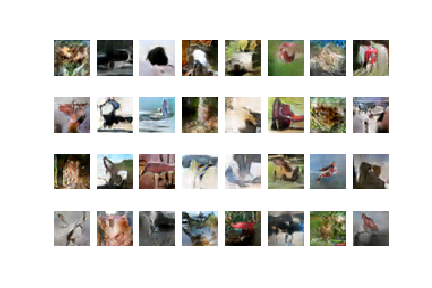

In [ ]:
Image(filename='generated_images_{}.png'.format(epochs - 1)) 